# ¿Que variables influyen en el precio de vivienda?

In [2]:
# Paquetes
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

%matplotlib inline

## Introducción (5 mts)

Aplicar Regularización L1 para reducir el número de variables y L2 para lidiar con multicolinearidady reducir aun más el número de variables.

In [4]:
# Ver datos
df = pd.read_csv('saratoga-houses_clean.csv')
df.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,0.132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,0.181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,0.109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,0.155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,0.086060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes


## Relaciones entre variables con visualizaciones (20 mts)

Empecemos por las numéricas y no categóricas:

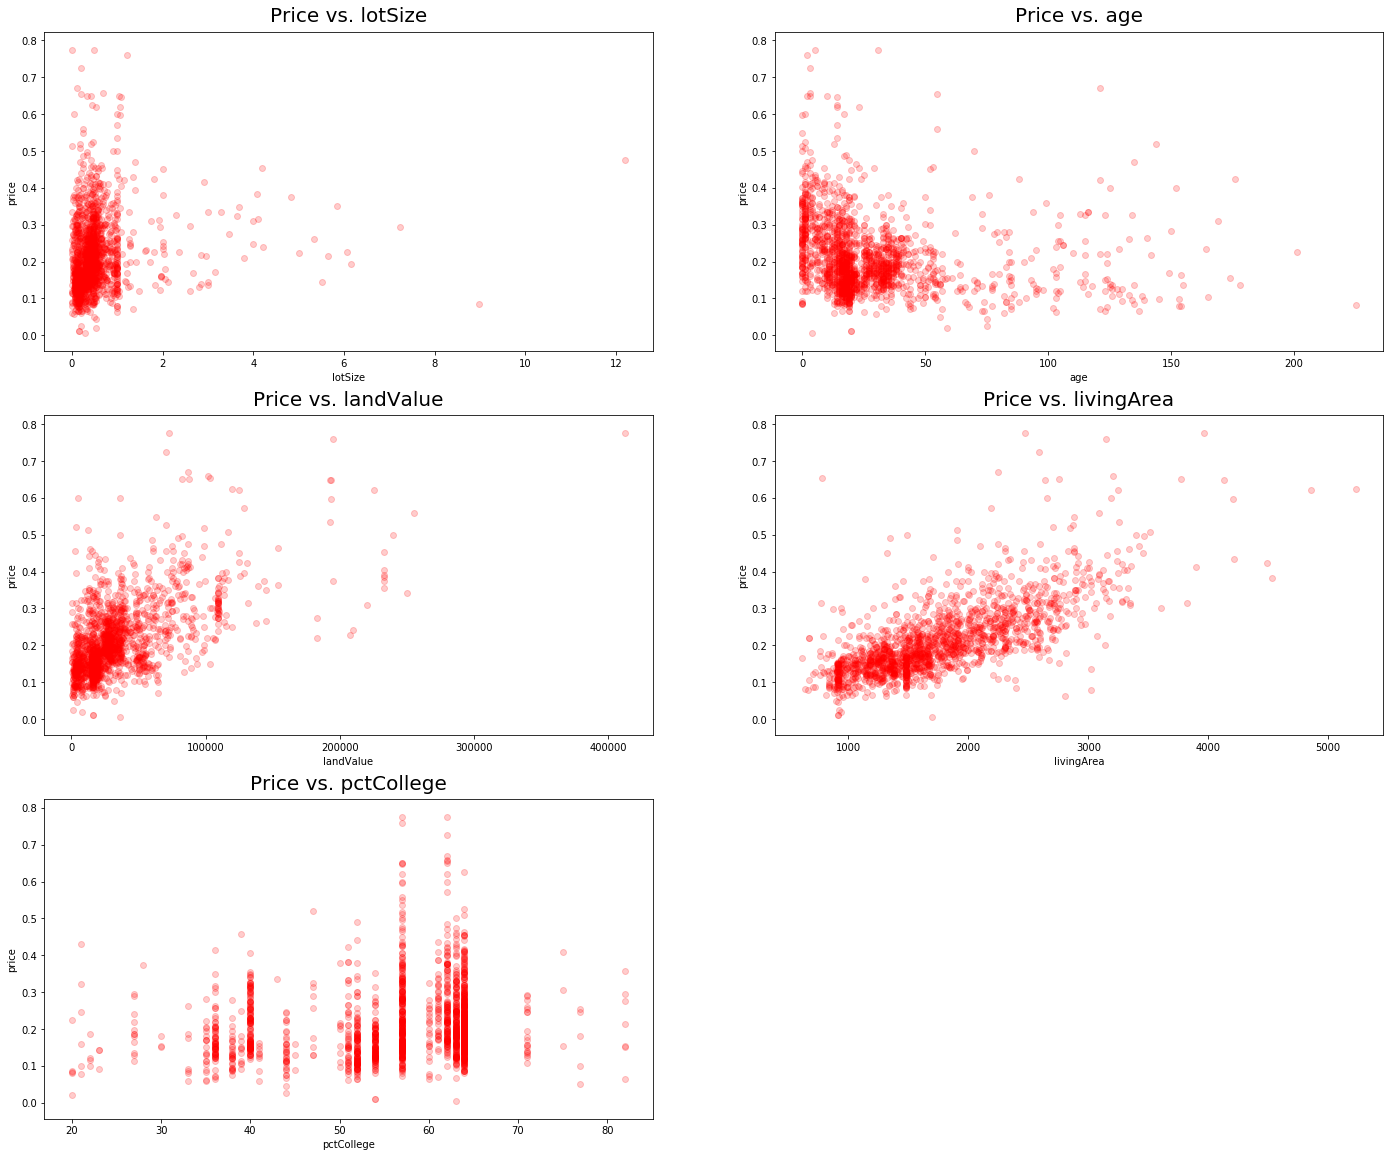

In [6]:
# Variables numéricas no categóricas
plt.figure(figsize=(24,20))
varstolook = ['lotSize', 'age', 'landValue', 'livingArea', 'pctCollege']
for i,feature in enumerate(varstolook):
    plt.subplot(3,2,i+1)
    colvalues = df[feature]
    plt.scatter(colvalues.values, df.price.values, alpha=0.20, edgecolor=None, color='red')
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title("Price vs. " + feature, fontsize=20, verticalalignment='bottom');

```livingArea```, ```landValue```, and ```lotSize``` positivamente correlacionados.

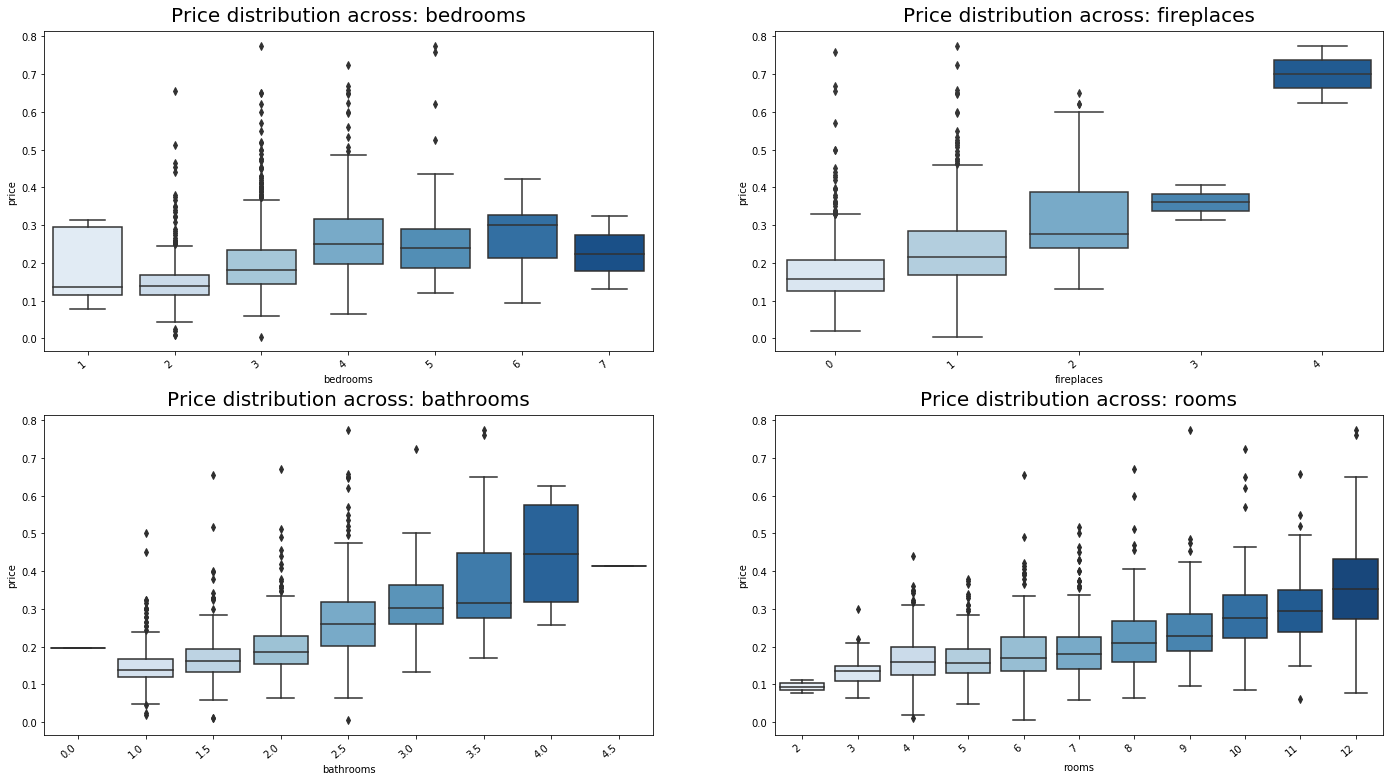

In [8]:
# Variables numpericas categóricas
plt.figure(figsize=(24,20))
varstolook = ['bedrooms', 'fireplaces', 'bathrooms', 'rooms']
for i,feature in enumerate(varstolook):
    plt.subplot(3,2,i+1)
    pl2 = sns.boxplot(x=feature, y = "price", data = df, palette="Blues")
    pl2.set_xticklabels(pl2.get_xticklabels(), rotation=40, ha="right");
    plt.title("Price distribution across: " + feature, fontsize=20, verticalalignment='bottom');

Fuerte relación de ```rooms```, ```bathrooms```, y ```fireplaces``` con los precios de vivienda.

### Ejercicio 1: (10 mts)

Crear diagramas de caja de las siguientes variables contra el precio:

1. `heating`
2. `fuel`
3. `sewer`
4. `waterfront`
5. `newConstruction`
6. `centralAir`

**Respuesta.** 

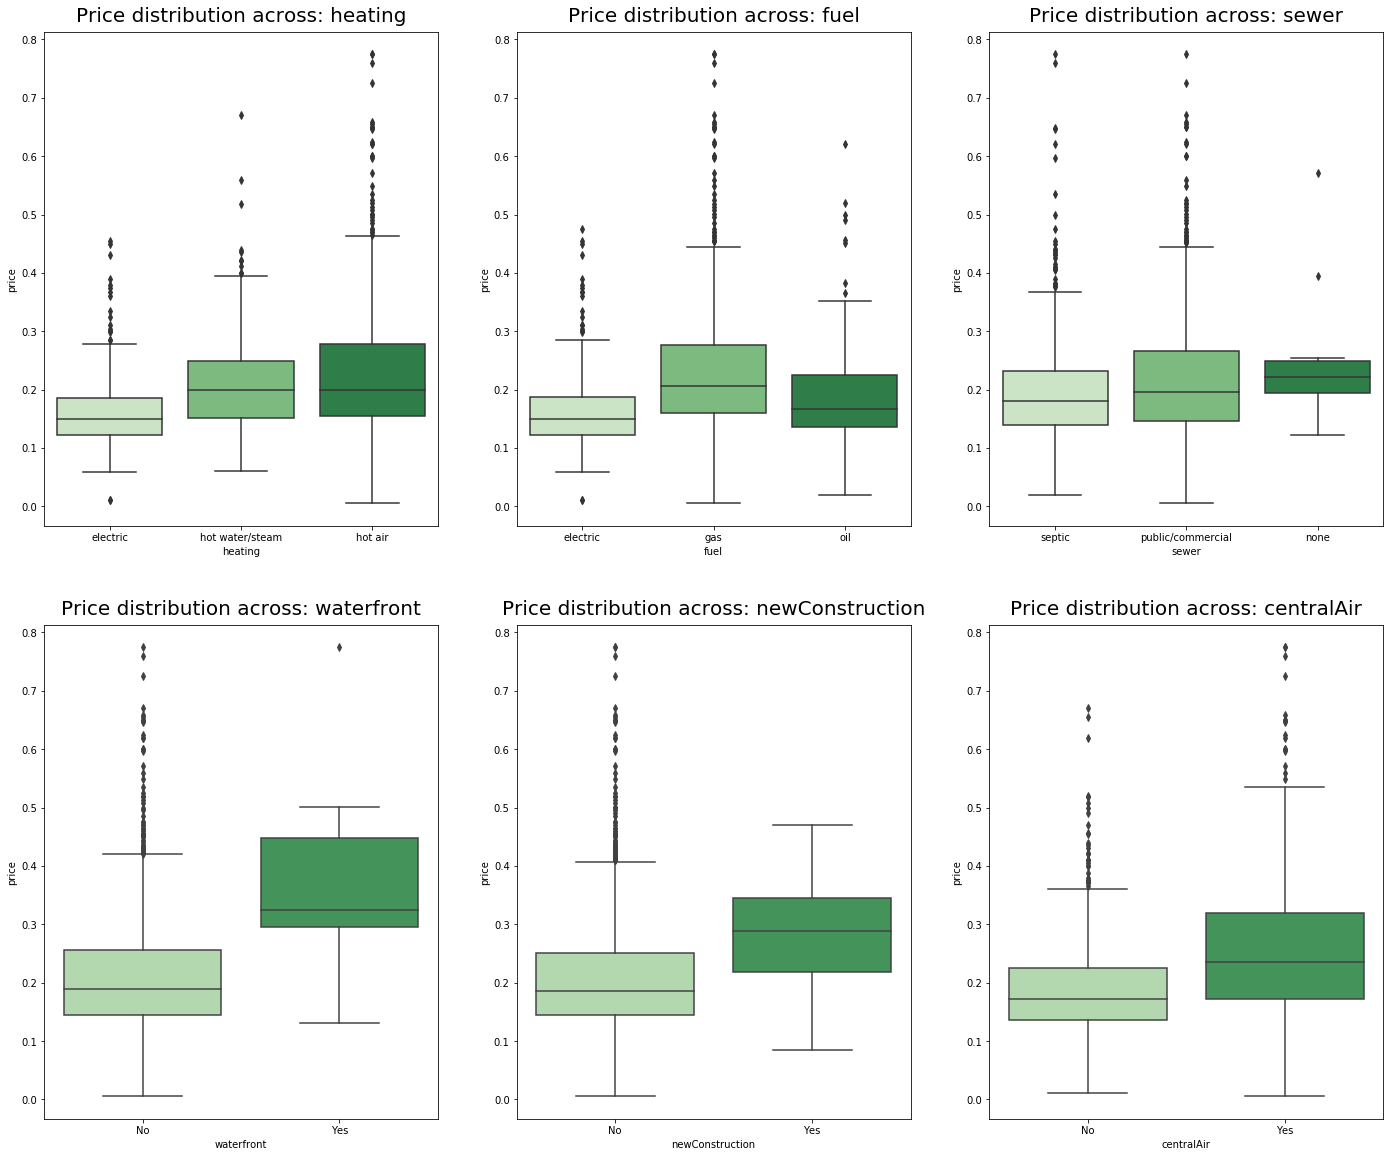

In [9]:
# Una posible solución
plt.figure(figsize=(24,20))
varstolook = ['heating', 'fuel','sewer', 'waterfront', 'newConstruction', 'centralAir']
for i,feature in enumerate(varstolook):
    plt.subplot(2,3,i+1)
    pl2 = sns.boxplot(x=feature, y = "price", data = df, palette="Greens")
    pl2.set_xticklabels(pl2.get_xticklabels(), rotation=0, ha="center");
    plt.title("Price distribution across: " + feature, fontsize=20, verticalalignment='bottom');

los residentes son diversos y mantienen una distribución similar de ingreso y educación

## Primer modelo (10 mts)

### Preparar los datos (5 mts)

Transformaciones simples:

In [11]:
# Codificar variables categóricas no numéricas
df2 = pd.get_dummies(df, columns=['heating', 'fuel'], drop_first=False)
df2 = pd.get_dummies(df2, columns=['sewer'], drop_first=True)
df2.replace({'waterfront': {"No":0, "Yes":1},
             'newConstruction': {"No":0, "Yes":1},
             'centralAir': {"No":0, "Yes":1}}, inplace=True)

Particionar los datos en entrenamiento y prueba.

In [12]:
# Alistar datos para regresión múltiple
X = df2.drop(['price'], axis=1)
y = df2[['price']].values.ravel()

# Partición
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Normalicemos los datos:

In [13]:
# Media y desviación estándar
training_mean = X_train.mean()
training_std =  X_train.std()

# Centrar los datos
X_train = (X_train - training_mean) / training_std 
X_test = (X_test - training_mean) / training_std

### Ajustar modelo de regresión múltiple (5 mts)

In [14]:
# Ajuste
model_linear = sm.OLS(y_train, sm.add_constant(X_train))
original_linear = model_linear.fit()
print(original_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     137.1
Date:                Fri, 21 Feb 2020   Prob (F-statistic):          1.22e-282
Time:                        16:38:05   Log-Likelihood:                 1838.2
No. Observations:                1296   AIC:                            -3638.
Df Residuals:                    1277   BIC:                            -3540.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Niveles de significancia acorde a las relaciones de las visualizaciones.

## ¿Cómo puede la regularización ayudar? (25 mts)

Es una penalización a los modelos con muchas variables, reduce la complejidad y previene el sobreajuste.

Utilizaremos **Regularización L1**

### Selección con LASSO (15 mts)

**LASSO (Least Absolute Shrinkage and Selection Operator) regression**. L1 agrega la magnitud absoluta de los coeficientes ($\beta_j$) al modelo de mínimos cuadrados ordinarios, multiplicado por un término de escalamiento $\lambda$:

$$\sum_{i=1}^N{\big(y_i - \sum_{j=1}^p{x_{ij}\beta_j}}\big)^2 + \color{red}{\lambda \sum_{j=1}^{p}\big| \beta_j \big|} .$$

Recall that mulitple linear regression seeks to minimize the objective function $Loss(Data\ |\ Model)$, where the loss is usually defined as the squared difference between predicted and true $y$ values (in this case $y$ is house prices). Extending multiple linear regression to use L1 regularization requires adding an extra term ${\lambda \sum_{j=1}^{p}\big| \beta_j \big|}$ to penalize increased model complexity.

El valor de $\lambda$ impone la fuerza de la regularización  – A mayor $\lambda$ mayor efecto sobre los coeficientes $\beta_j$

```alpha``` se refiere al $\lambda$ definido arriba. Al principio ponemos un valor bajo para probar que este proceso sea inncesario.

In [15]:
# Ajustando modelo L1
model_l1 = linear_model.Lasso(alpha=0.00001, fit_intercept=True)
results_l1 = model_l1.fit(X_train, y_train)

Para valores cercanos a cero quiere decir que se removieron las variables:

In [16]:
sorted(zip(X_train.columns, results_l1.coef_), key=lambda x: x[1])

[('sewer_public/commercial', -0.013232781041673514),
 ('sewer_septic', -0.010787648875029972),
 ('newConstruction', -0.010751135709249762),
 ('bedrooms', -0.0055783017733662815),
 ('age', -0.0051973811927718315),
 ('heating_hot water/steam', -0.0032711053509304226),
 ('fuel_electric', -0.0013733902247770112),
 ('pctCollege', -0.00011477706533155446),
 ('heating_electric', -0.0),
 ('fuel_oil', -0.0),
 ('fireplaces', 0.0006947901157847477),
 ('heating_hot air', 0.0011599235531580224),
 ('fuel_gas', 0.002415840776399001),
 ('lotSize', 0.0037320106441614733),
 ('centralAir', 0.004876517833592995),
 ('rooms', 0.006969691924555496),
 ('waterfront', 0.009729752501652256),
 ('bathrooms', 0.014290925997177384),
 ('landValue', 0.033581630776893426),
 ('livingArea', 0.044219524339685144)]

**heating_electric** y **fuel_oil** son cero.

Remover las variables y seguir:

In [17]:
# Reducir número de variables
cols_to_drop = ['heating_electric','fuel_oil']
X_train_simplified = X_train.drop(columns=cols_to_drop)
X_test_simplified = X_test.drop(columns=cols_to_drop)

In [18]:
# Re-ajustar modelo
model_linear = sm.OLS(y_train, sm.add_constant(X_train_simplified))
res_linear = model_linear.fit()
print(res_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     137.1
Date:                Fri, 21 Feb 2020   Prob (F-statistic):          1.22e-282
Time:                        17:00:39   Log-Likelihood:                 1838.2
No. Observations:                1296   AIC:                            -3638.
Df Residuals:                    1277   BIC:                            -3540.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

El mismo R-Cuadrado, se redujo la complejidad exitosamente.

Basado en lo anterior la mejor situación para aplicar la regularización es cuando tenemos altas cantidades de variables

### Identificar multicolinearidad y remover más variables (5 mts)

Miremos las correlaciones de las variables numéricas no categóricas:

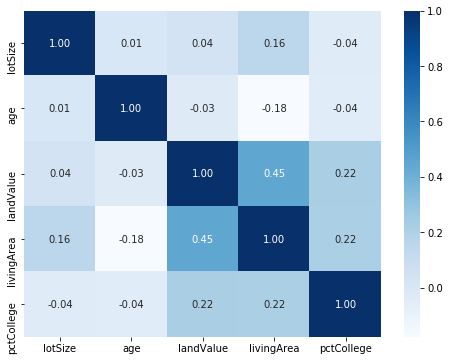

In [19]:
# Mapa de calor de las correlaciones
features = ['lotSize', 'age', 'landValue', 'livingArea', 'pctCollege']
fig, ax = plt.subplots(figsize=(8,6))
corr = X_train_simplified[features].corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, cmap="Blues", annot=True, fmt=".2f");

Podemos ver una correlación moderada entre 2 variables. No es terrrible pero para propósitos de precisión no es ideal.

Para este caso utilizamos **regularización L2**, la cual es bastante buena lidiando con multicolinearidad:

## Aplicando regularización L2 (25 mts)

**Ridge regression (regresión de arista)**. Le agrega la magnitud al cuadrado de los coeficientes ($\beta_j$) al modelo de mínimos cuadrados ordinarios:

$$\sum_{i=1}^N{\big(y_i - \sum_{j=1}^p{x_{ij}\beta_j}}\big)^2 + \color{red}{\lambda \sum_{j=1}^{p}\beta_j^2} .$$

In [21]:
# Ajustando el modelo
model_l2 = linear_model.Ridge(alpha=28.0, fit_intercept=True)
results_l2 = model_l2.fit(X_train_simplified, y_train)

In [22]:
sorted(zip(X_train_simplified.columns, results_l2.coef_), key=lambda x: x[1])

[('newConstruction', -0.010097504317072277),
 ('sewer_public/commercial', -0.005645526782576303),
 ('age', -0.0051927861446084645),
 ('bedrooms', -0.004616405925118675),
 ('sewer_septic', -0.0033133856339937),
 ('heating_hot water/steam', -0.0028375626579345992),
 ('fuel_electric', -0.0011615800651066867),
 ('pctCollege', 6.581924953498728e-05),
 ('fireplaces', 0.0012042793203154293),
 ('heating_hot air', 0.001673676719471996),
 ('fuel_gas', 0.002269941382553904),
 ('lotSize', 0.003852235288187073),
 ('centralAir', 0.005066594564126546),
 ('rooms', 0.007718915340688878),
 ('waterfront', 0.009718016717086513),
 ('bathrooms', 0.01479000907340026),
 ('landValue', 0.033136996357939784),
 ('livingArea', 0.041428583014597946)]

Veremos cómo escoger gráficamente el valor de $\lambda$ porque este cambia drásticamente los resultados de la regresión.

### Efectos de $\lambda$ en el subajuste y sobreajuste (20 mts)

Iteremos sobre valores de $\lambda$ y veamos sus efectos. Compararemos el desempeño en entrenamiento y prueba. Valor más altos de $\lambda$ conllevan una regularización más fuerte.

In [23]:
# Bucle
lambdas = np.arange(0.1, 100.0, 0.1)

coefs = []
mse_train = []
mse_test = []
for l in lambdas:
    ridge = linear_model.Ridge(alpha=l, fit_intercept=True)
    ridge.fit(X_train_simplified, y_train)
    mse_train.append(mean_squared_error(y_train, ridge.predict(X_train_simplified))) # train data
    mse_test.append(mean_squared_error(y_test, ridge.predict(X_test_simplified))) # test data

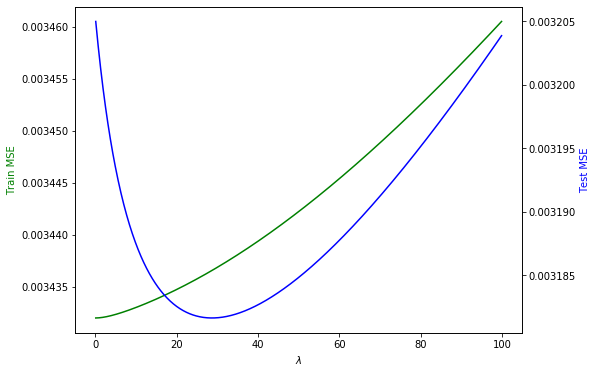

In [24]:
# Graficar resultados
fig, ax1 = plt.subplots(figsize=(8,6))

ax2 = ax1.twinx()
ax1.plot(lambdas, mse_train, 'g-')
ax2.plot(lambdas, mse_test, 'b-')

ax1.set_xlabel('$\lambda$')
ax1.set_ylabel('Train MSE', color='g')
ax2.set_ylabel('Test MSE', color='b')

plt.show()

El modelo se sobreajusta con $\lambda$ pequeños. El MSE es mucho mayor en ese caso.

El modelo se subajusta cuando $\lambda$ es grande, con MSE también grande.

Por ende, se necesita un lambda intermedio - gráficamente el mínimo se alcanza alrededor de 28.

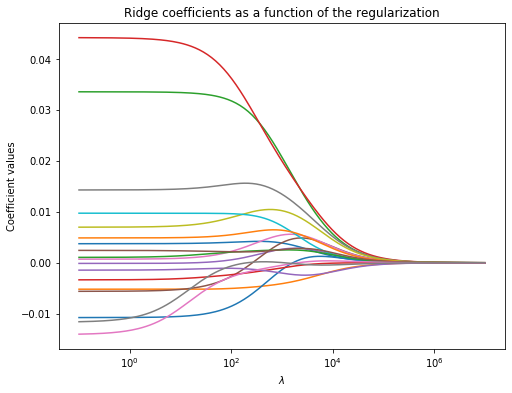

In [19]:
Image("ridge_coef_plot.png", width=500)

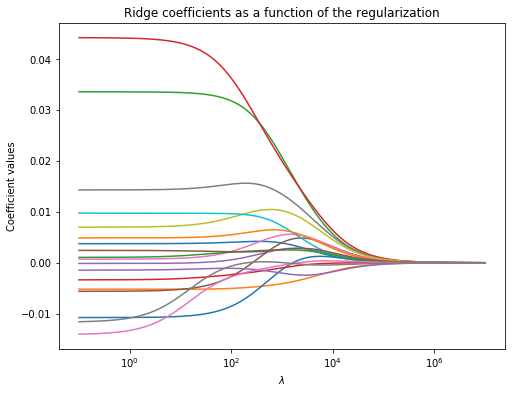

In [25]:
# Iterar y guardar los coeficientes
lambdas = np.logspace(-1, 7, 200)

coefs = []
for l in lambdas:
    ridge = linear_model.Ridge(alpha=l, fit_intercept=True)
    ridge.fit(X_train_simplified, y_train)
    coefs.append(ridge.coef_)

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(lambdas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  # reverse axis
plt.xlabel('$\lambda$')
plt.ylabel("Coefficient values")
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()
#plt.savefig('ridge_coef_plot.png', bbox_inches='tight')

Los valores de $\lambda$ deben de escogerse con cuidado, sin embrago, la regularización es una herramienta muy poderosa.

## Elastic Net (35 mts)

Combianando L1 y L2 se obtiene **Elastic Net regression**.

L1:

$$Loss(Data\ |\ Model) + \color{red}{\lambda \sum_{j=1}^{p}\big| \beta_j \big|} .$$

L2:

$$Loss(Data\ |\ Model) + \color{red}{\lambda \sum_{j=1}^{p}\beta_j^2} .$$

$$\sum_{i=1}^{n} (y_i - \sum_{j=1}^{p} x_{ij} \beta_j)^2 + \color{red}{\alpha \rho \sum_{j=1}^{p}\big| \beta_j \big|} + \color{red}{\alpha(1-\rho) \sum_{j=1}^{p}\beta_j^2}.$$

Aquí, $\alpha$ es la tasa de regularización, y $\rho$ controla el balance entre L1 y L2 en la función de pérdida. $\rho = 1$ termina en L1, $\rho = 0$ resulta en L2, mientras que $0 < \rho < 1$ resulta en una combinación elástica de ambas.

In [26]:
# Bucle sobre varios valores de Alpha
alpha_list = np.logspace(-5, 1, 50)

coefs = []
for a in alpha_list:
    enet = linear_model.ElasticNet(random_state=0, alpha=a, l1_ratio=0.5, fit_intercept=True)
    enet.fit(X_train_simplified, y_train)
    coefs.append(enet.coef_.ravel())

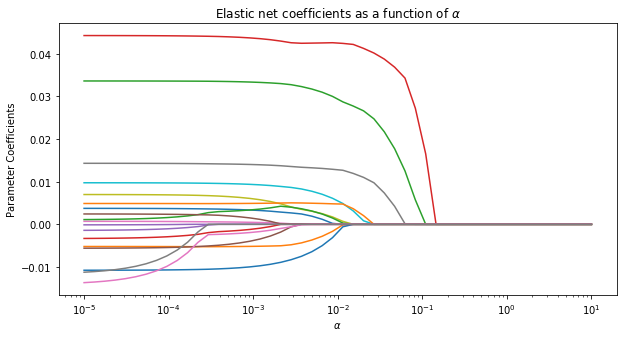

In [27]:
# Graficar
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alpha_list, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  # reverse axis
plt.xlabel(r'$\alpha$')
plt.ylabel('Parameter Coefficients')
plt.title(r'Elastic net coefficients as a function of $\alpha$')
plt.axis('tight');

Cuando $\alpha$ se incrementa más allá de ~0.1, todos los coeficientes se vuelven cero. $\alpha$ pequeño termina en regularización muy débil. Cuando $\alpha$ disminuyen de derecha a izquierda, las estimaciones es afectan significativamente cerca a $10^{-4}$. Esto indica el punto en que la regularización empieza a tener efecto.

### Escoger $\alpha$ óptimo (10 mts)

Observar el R-Cuadrado como una función de $\alpha$:

In [28]:
# Comparación
alphas = np.logspace(-5, 1, 50)
enet = linear_model.ElasticNet(random_state=0, l1_ratio=0.5, fit_intercept=True)
train_errors = list()
test_errors = list()
for alpha in alphas:
    enet.set_params(alpha=alpha)
    enet.fit(X_train_simplified, y_train)
    train_errors.append(enet.score(X_train_simplified, y_train))
    test_errors.append(enet.score(X_test_simplified, y_test))

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print("Optimal alpha regularization parameter : %.6f" % alpha_optim)

# Estimate the coef_ on full data with optimal regularization parameter
enet.set_params(alpha=alpha_optim)
coef_ = enet.fit(X, y).coef_

Optimal alpha regularization parameter : 0.000518


Evolución del R-Cuadrado ante cambios de $\alpha$

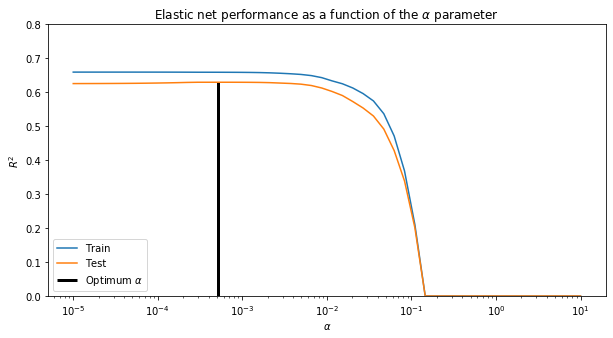

In [29]:
# Graficar
fig,ax = plt.subplots(figsize=(10,5))
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',linewidth=3, label=r'Optimum $\alpha$')
plt.legend(loc='lower left')
plt.ylim([0, 0.8])
plt.title(r'Elastic net performance as a function of the $\alpha$ parameter')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$R^2$');

El valor óptimo de  $\alpha$ es aproximadamente 0.0005.

### Exercise 7: (15 mts)

Calcular valores óptimos de $\alpha$ cuando $\rho$ tome estos valores: [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

**Respuesta**

In [32]:
# Comparación cuando rho es el parámetro que cambia
alphas = np.logspace(-5, 1, 50)
rhos = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
list_alpha_optim = []
for rho in rhos:
    train_errors = []
    test_errors = []
    enet = linear_model.ElasticNet(random_state=0, l1_ratio=0.5, fit_intercept=True)
    for alpha in alphas:
        enet.set_params(alpha=alpha, l1_ratio=rho)
        enet.fit(X_train_simplified, y_train)
        train_errors.append(enet.score(X_train_simplified, y_train))
        test_errors.append(enet.score(X_test_simplified, y_test))

    i_alpha_optim = np.argmax(test_errors)
    alpha_optim = alphas[i_alpha_optim]
    print("Optimal alpha for rho = %.6f: %.6f" % (rho, alpha_optim))
    list_alpha_optim.append(alpha_optim)

Optimal alpha for rho = 0.100000: 0.002121
Optimal alpha for rho = 0.200000: 0.001207
Optimal alpha for rho = 0.300000: 0.000910
Optimal alpha for rho = 0.400000: 0.000687
Optimal alpha for rho = 0.500000: 0.000518
Optimal alpha for rho = 0.600000: 0.000518
Optimal alpha for rho = 0.700000: 0.000391
Optimal alpha for rho = 0.800000: 0.000391
Optimal alpha for rho = 0.900000: 0.000295



Nos damos cuenta que el alpha óptimo decrece cuando $\rho$ decrece.

## Aspectos importantes del modelo Elastic Net (5 mts)

Encontramos un óptimo $\alpha = 0.000518$

In [33]:
# Coeficientes del modelo final
final_elastic_net_model = linear_model.ElasticNet(random_state=0, alpha=0.000518, l1_ratio=0.5, fit_intercept=True)
final_elastic_net_model.fit(X_train_simplified, y_train)
sorted(zip(X_train_simplified.columns, final_elastic_net_model.coef_), key=lambda x: x[1])

[('newConstruction', -0.010326892226584089),
 ('age', -0.005216691646158036),
 ('bedrooms', -0.004675685635988087),
 ('sewer_public/commercial', -0.00224622292331844),
 ('heating_hot water/steam', -0.0015928929103743252),
 ('pctCollege', -0.0),
 ('fuel_electric', -0.0),
 ('sewer_septic', -0.0),
 ('fireplaces', 0.0005434853927543258),
 ('fuel_gas', 0.001967178310464723),
 ('heating_hot air', 0.0030686697632882555),
 ('lotSize', 0.0035138915694130878),
 ('centralAir', 0.004870730698973056),
 ('rooms', 0.0064860340858468295),
 ('waterfront', 0.009525337302894225),
 ('bathrooms', 0.014121489970889517),
 ('landValue', 0.03345216803179956),
 ('livingArea', 0.04392189129273642)]


Los precios están muy positivamente influenciados por **livingArea** and **landValue**



**newConstruction** y **age** tienen betas bastante negativos. La relación con la edad es intuitiva, pero con las nuevas construcciones no tanto. Esto amerita un estudio más profundo de esta variable.